# Daily Time Series Forecasting using Facebook's Prophet

![Prophet](https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png)

In this notebook, we will use Facebook's Prophet package to forecast daily page loads for a website.

**Note that this is not our data; this is from [Kaggle](https://www.kaggle.com/datasets/bobnau/daily-website-visitors/data).**

In [1]:
import numpy as np  # Importing NumPy library for numerical operations
import pandas as pd  # Importing Pandas library for data manipulation and analysis
import seaborn as sns  # Importing Seaborn library for data visualization
import matplotlib.pyplot as plt  # Importing Matplotlib library for creating plots

from prophet import Prophet  # Importing Prophet from Facebook's Prophet library for time series forecasting

from sklearn.metrics import mean_squared_error, mean_absolute_error  # Importing evaluation metrics from scikit-learn library

import warnings  # Importing warnings module to handle warnings
warnings.filterwarnings("ignore")  # Ignore warnings during runtime

plt.style.use('ggplot')  # Setting the plot style to 'ggplot'
plt.style.use('fivethirtyeight')  # Setting the plot style to 'fivethirtyeight'

def mean_absolute_percentage_error(y_true, y_pred):  # Defining a function to calculate Mean Absolute Percentage Error (MAPE)
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)  # Converting input arrays to NumPy arrays
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Calculating MAPE and returning the result

# Data
The data we will be using is a 5 years of daily page loads for a website whose alias is statforecasting.com. The data has seasonal patterns linked to both the day of the week and the academic calendar. These patterns resemble those found in other daily datasets affected by day-of-week and time-of-year variations.

**Content**
The variables are daily counts of page loads, unique visitors, first-time visitors, and returning visitors to an academic teaching notes website. The data that we will try to forecast is the daily counts of page loads. The data was collected through a traffic monitoring service known as StatCounter.

The advantages of forecasting daily counts of page loads on a statistical forecasting teaching notes website like statforecasting.com offers several advantages:

**Insight into Traffic** Patterns: By forecasting page loads, we gain insights into the website's traffic patterns over time. Understanding these patterns helps in resource allocation, content scheduling, and overall website management.

**Identifying Seasonal Trends:** The data's complex seasonality, linked to both the day of the week and the academic calendar, allows us to identify and analyze seasonal trends. This information can be valuable for planning marketing campaigns, promotions, and content updates aligned with peak traffic periods.

**Support for Decision Making:** Accurate forecasts enable better decision-making processes. For example, knowing when to expect high traffic days can help in scheduling server maintenance, scaling resources, and optimizing website performance during peak periods.

**Improving User Experience:** By anticipating fluctuations in page loads, website administrators can ensure a smooth user experience by optimizing site performance and content delivery mechanisms.

**Resource Allocation:** Forecasting page loads assists in optimizing resource allocation, such as server capacity and bandwidth, to accommodate varying levels of website traffic efficiently.

**Evaluation of Marketing Efforts:** Tracking forecasted versus actual page loads helps evaluate the effectiveness of marketing initiatives, content strategies, and promotional activities aimed at driving traffic to the website.

**Enhanced Planning and Budgeting:** Accurate forecasts provide a basis for budgeting and resource planning for future periods. This includes staffing levels, marketing budgets, and infrastructure investments tailored to expected traffic levels.

In summary, forecasting daily page loads offers valuable insights into website traffic patterns, supports decision-making processes, improves user experience, and enhances resource allocation and planning efforts for website management and optimization.

**Note that this is not our data this is from https://www.kaggle.com/datasets/bobnau/daily-website-visitors/data**

In [2]:
df = pd.read_csv('data.csv')  # Reading the CSV file into a DataFrame

# Selecting specific columns from the DataFrame
selected_columns = df[['Day', 'Day.Of.Week', 'Date', 'Page.Loads']]
selected_columns.head()

,Day,Day.Of.Week,Date,Page.Loads
0,Sunday,1,9/14/2014,"2,146"
1,Monday,2,9/15/2014,"3,621"
2,Tuesday,3,9/16/2014,"3,698"
3,Wednesday,4,9/17/2014,"3,667"
4,Thursday,5,9/18/2014,"3,316"


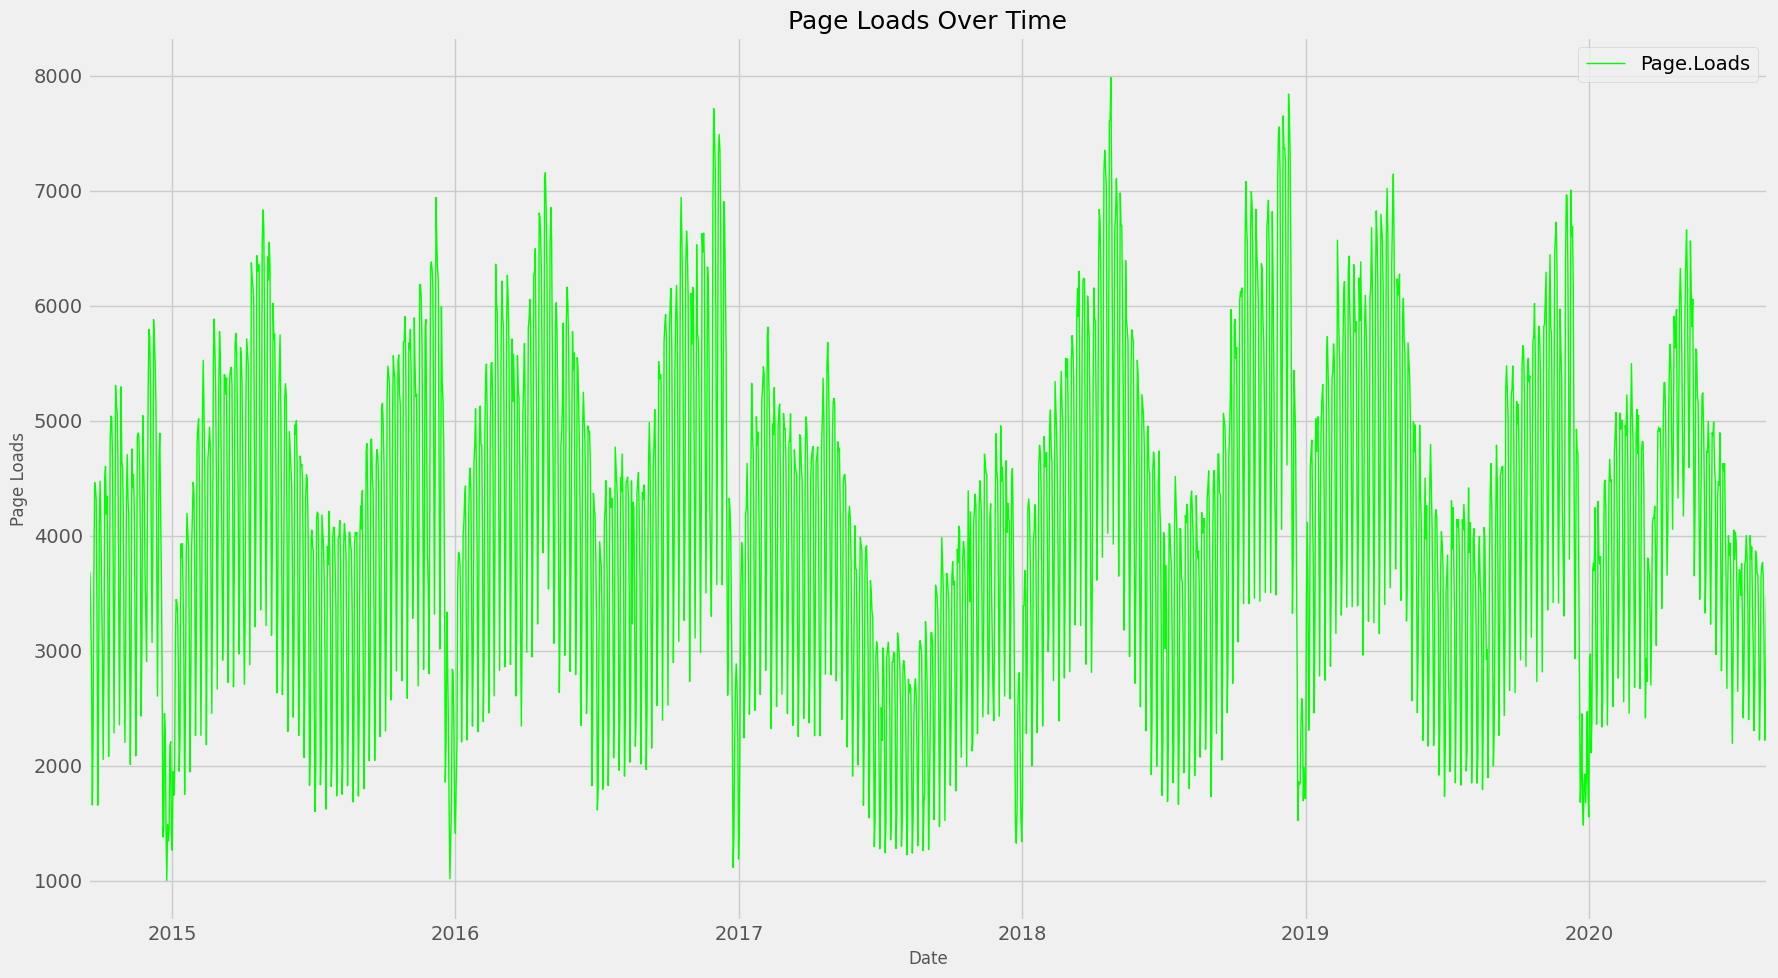

In [3]:
# Remove commas from the 'Page.Loads' column and convert it to numeric
selected_columns['Page.Loads'] = selected_columns['Page.Loads'].str.replace(',', '').astype(int)

# Convert the 'Date' column to datetime format
selected_columns['Date'] = pd.to_datetime(selected_columns['Date'])

# Create a new figure and axis object for the plot
fig, ax = plt.subplots(figsize=(18, 10))

# Plot 'Page Loads' over time
selected_columns.plot(x='Date', y='Page.Loads', ax=ax, color="lime", linestyle="-", linewidth=1, markersize=8)

# Set the title of the plot
ax.set_title("Page Loads Over Time", fontsize=18)

# Set the label for the x-axis
ax.set_xlabel("Date", fontsize=12)

# Set the label for the y-axis
ax.set_ylabel("Page Loads", fontsize=12)

# Adjust the layout of the plot to prevent overlap of axis labels
fig.tight_layout()

# Display the plot
plt.show()

# Time series Features 

 ## Description:
This code generates a box plot to visualize the distribution of 'Page Loads' by 'Day of Week'. The data is extracted from the selected_columns DataFrame, which contains information about the day of the week and the corresponding page loads. The box plot helps to identify the central tendency, spread, and potential outliers in the data for each day of the week. This visualization can provide insights into any patterns or trends in website traffic throughout the week.

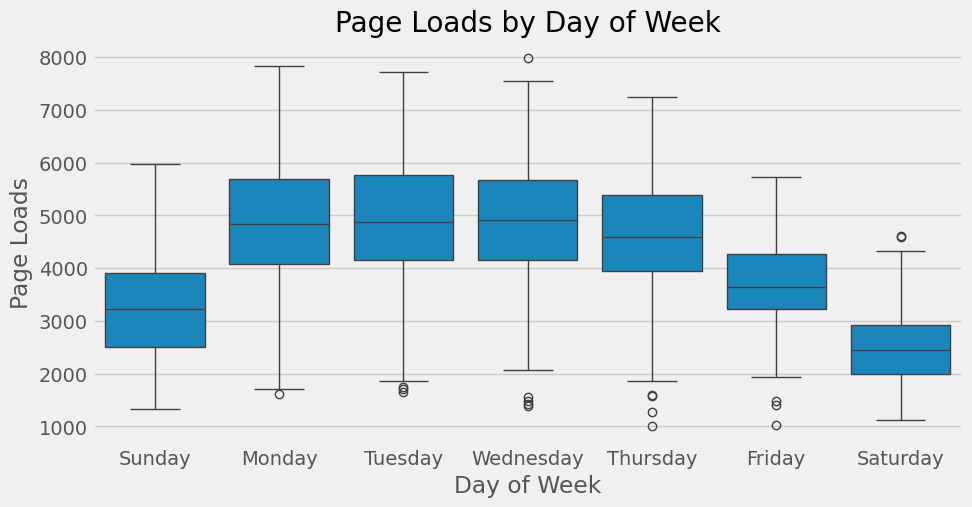

In [4]:
# Plotting
# Create a new figure and axis object for the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Use seaborn's boxplot function to visualize the distribution of 'Page Loads' by 'Day'
sns.boxplot(data=selected_columns.dropna(),
            x='Day',
            y='Page.Loads',
            ax=ax,
            linewidth=1)

# Set the title of the plot
ax.set_title('Page Loads by Day of Week')

# Set the label for the x-axis
ax.set_xlabel('Day of Week')

# Set the label for the y-axis
ax.set_ylabel('Page Loads')

# Display the plot
plt.show() 

## Description:
This code defines a function get_season() to map months to seasons and applies it to the 'Date' column in the selected_columns DataFrame. The 'Month' column is created to store the month extracted from the 'Date' column, and then it's mapped to seasons using the defined function, resulting in a new 'Season' column. The box plot visualizes the distribution of 'Page Loads' by season, allowing for the comparison of website traffic across different seasons. This visualization helps in understanding any seasonal patterns or trends in website traffic.

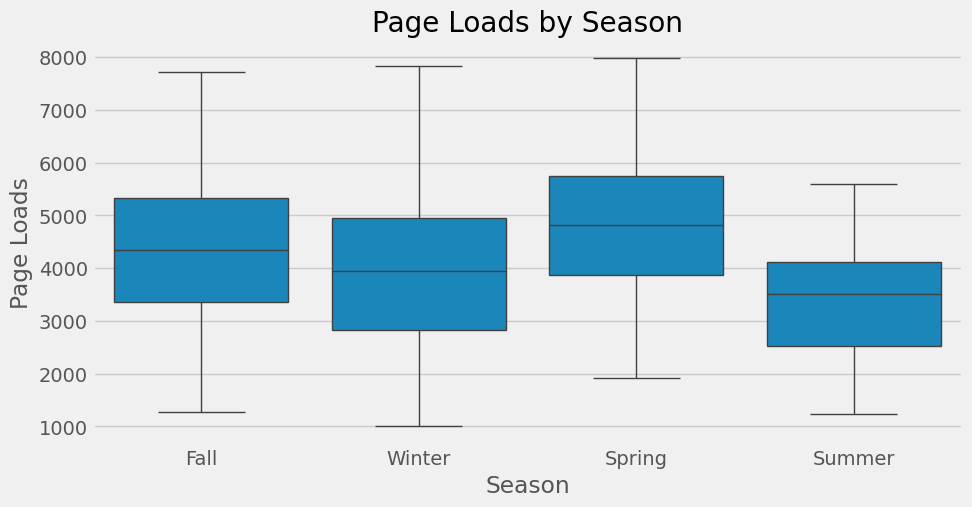

In [5]:
 # Define a function to map months to seasons
def get_season(month):
    # Map the month to the corresponding season
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Extract month from the 'Date' column and map it to seasons
selected_columns['Month'] = selected_columns['Date'].dt.month
selected_columns['Season'] = selected_columns['Month'].apply(get_season)

# Plotting
# Create a new figure and axis object for the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Use seaborn's boxplot function to visualize the distribution of 'Page Loads' by 'Season'
sns.boxplot(data=selected_columns.dropna(),
            x='Season',
            y='Page.Loads',
            ax=ax,
            linewidth=1)

# Set the title of the plot
ax.set_title('Page Loads by Season')

# Set the label for the x-axis
ax.set_xlabel('Season')

# Set the label for the y-axis
ax.set_ylabel('Page Loads')

# Display the plot
plt.show()

# Training the model

In [6]:
selected_columns.dtypes

Day                    object
Day.Of.Week             int64
Date           datetime64[ns]
Page.Loads              int32
Month                   int32
Season                 object
dtype: object

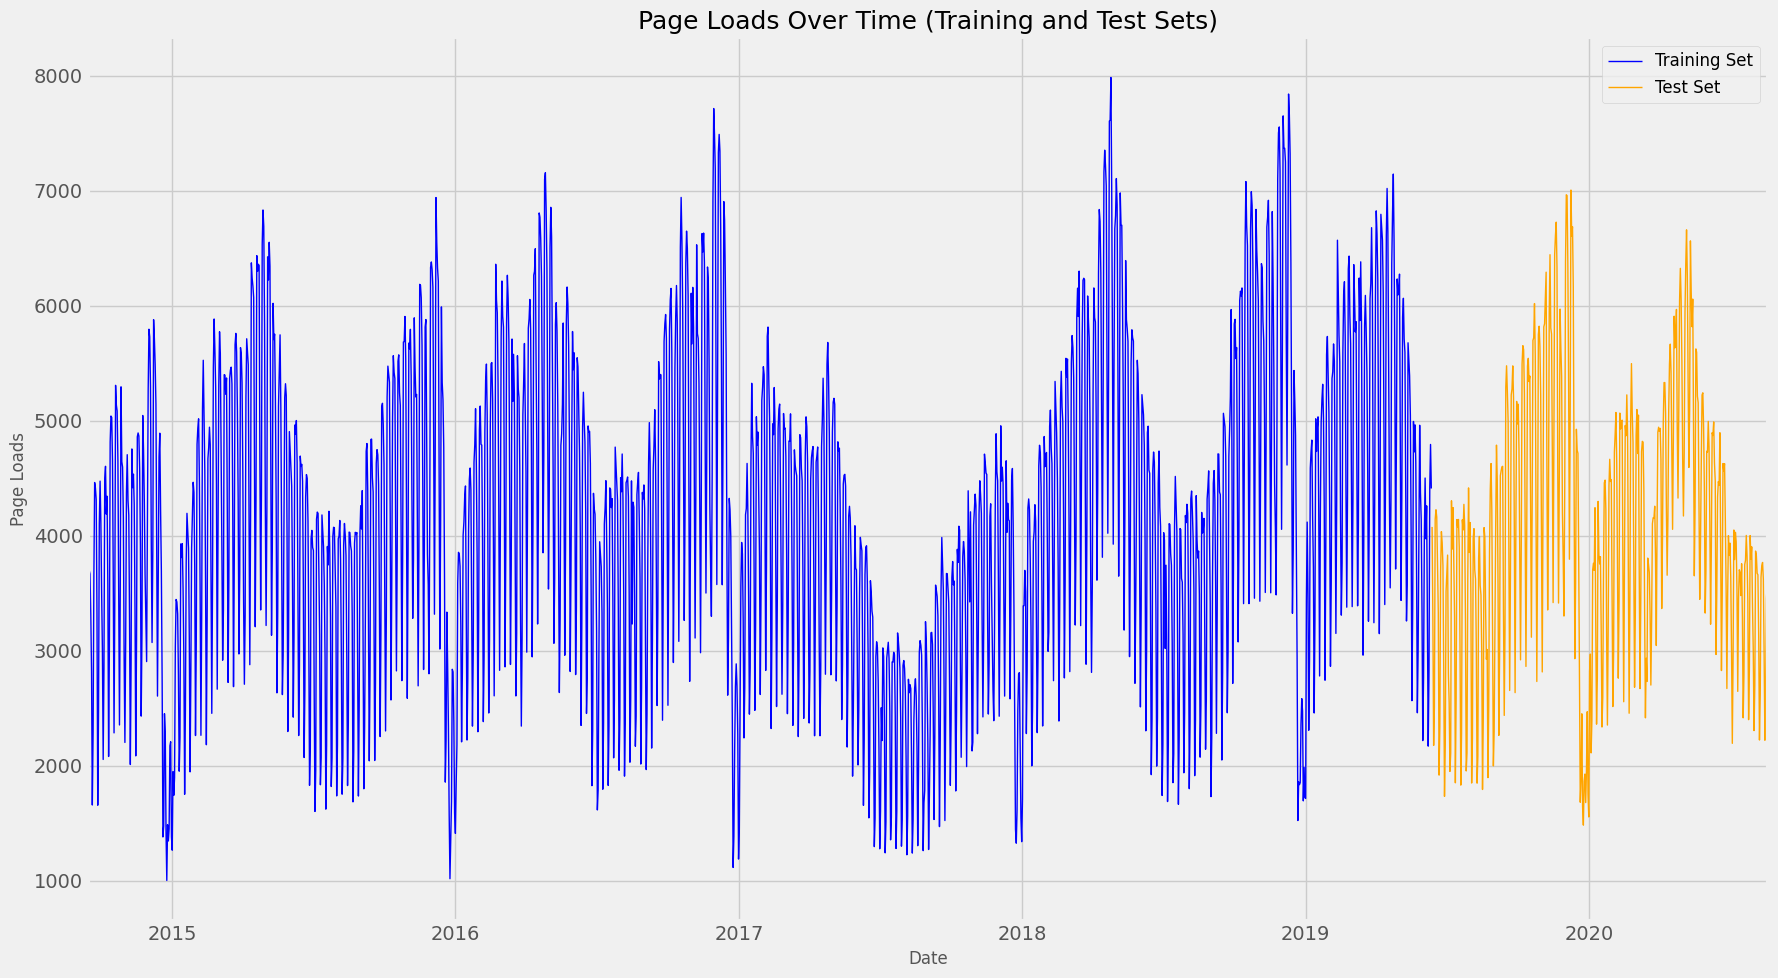

In [7]:
# Convert the 'Date' column to datetime format
selected_columns['Date'] = pd.to_datetime(selected_columns['Date'])

# Sort the data by date
selected_columns = selected_columns.sort_values('Date')

#use an 80 / 20 split for the training and test sets
split_index = int(len(selected_columns) * 0.8)

# Split the data into training and test sets
df_train = selected_columns.iloc[:split_index].copy()
df_test = selected_columns.iloc[split_index:].copy()

# Create a new figure and axis object for the plot
fig, ax = plt.subplots(figsize=(18, 10))

# Plot 'Page Loads' over time for training and test sets
df_train.plot(x='Date', y='Page.Loads', ax=ax, color="blue", linestyle="-", linewidth=1, markersize=8, label='Training Set')
df_test.plot(x='Date', y='Page.Loads', ax=ax, color="orange", linestyle="-", linewidth=1, markersize=8, label='Test Set')

# Set the title of the plot
ax.set_title("Page Loads Over Time (Training and Test Sets)", fontsize=18)

# Set the label for the x-axis
ax.set_xlabel("Date", fontsize=12)

# Set the label for the y-axis
ax.set_ylabel("Page Loads", fontsize=12)

# Add a legend to the plot
plt.legend(fontsize=12)

# Adjust the layout of the plot to prevent overlap of axis labels
fig.tight_layout()

# Display the plot
plt.show()

# Prophet Model test 1 

Before feeding our dataset into the Prophet model, we need to adhere to its specific column naming conventions. This entails renaming the columns of our dataframe: the datetime column should be named 'ds', and the target variable should be named 'y'.

## Discription 
In this code section, we are utilizing Facebook's Prophet library to perform time series forecasting on website visitors' page loads. Let's break down the steps and provide a comprehensive description:

Column Renaming for Prophet Model:

We rename the columns of the training dataset (pjme_train) to adhere to Prophet's expected input format. Specifically, we rename the 'Date' column to 'ds' (representing datetime) and the 'Page.Loads' column to 'y' (representing the target variable to be forecasted). This step ensures compatibility with Prophet's modeling requirements.
Prophet Model Training:

We instantiate a Prophet model and fit it to the training data (pjme_train_prophet). Prophet automatically detects seasonality patterns and trends in the data during the training process, making it a powerful tool for time series forecasting.
Prediction on Test Set:

After training the Prophet model, we rename the columns of the test dataset (pjme_test) to match the required format ('ds' for datetime and 'y' for the target variable). We then use the trained model to make predictions on this test set, generating forecasts for future page loads.
Plotting the Forecast:

We create a plot to visualize the forecasted page loads alongside the actual values. The model.plot() function generates a graph that overlays the predicted values on top of the observed data points from the test set. This provides a visual comparison between the forecasted trends and the actual page load behavior.
Component Analysis:

Additionally, Prophet offers the capability to analyze different components of the time series, such as trend and seasonality. The model.plot_components() function generates separate plots for each component, allowing us to inspect how these factors contribute to the overall forecast.
Overall, this code segment demonstrates the application of Prophet for time series forecasting, encompassing model training, prediction, visualization of forecasts, and analysis of key components. It empowers businesses to make informed decisions based on accurate predictions of future website traffic.

In [8]:
# Rename columns for Prophet model 
# Renaming columns of the training dataset to adhere to Prophet's expected input format
df_train_prophet = df_train.rename(columns={'Date':'ds', 'Page.Loads':'y'})

In [9]:
%%time
# Create and fit the Prophet model
# Instantiating a Prophet model and training it with the training data
model = Prophet()
model.fit(df_train_prophet)

15:24:37 - cmdstanpy - INFO - Chain [1] start processing
15:24:37 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 125 ms
Wall time: 799 ms


In [10]:
# Rename columns for Prophet model in the test set
# Renaming columns of the test dataset to match the required format for Prophet
df_test_prophet = df_test.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Predict on the test set
# Using the trained Prophet model to make predictions on the test set
df_test_fcst = model.predict(df_test_prophet)
df_test_fcst.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
429,2020-08-15,4102.283774,-255.411108,3072.912058,2580.604286,5497.094316,-2604.611169,-2604.611169,-2604.611169,-1681.741154,-1681.741154,-1681.741154,-922.870015,-922.870015,-922.870015,0.0,0.0,0.0,1497.672605
430,2020-08-16,4101.572709,635.262961,3852.633740,2574.018566,5500.498938,-1832.904667,-1832.904667,-1832.904667,-912.118244,-912.118244,-912.118244,-920.786422,-920.786422,-920.786422,0.0,0.0,0.0,2268.668042
431,2020-08-17,4100.861643,2295.694885,5484.626981,2570.259991,5503.903560,-154.898777,-154.898777,-154.898777,764.997769,764.997769,764.997769,-919.896546,-919.896546,-919.896546,0.0,0.0,0.0,3945.962866
432,2020-08-18,4100.150577,2471.979568,5615.038807,2566.578946,5507.308181,-39.347309,-39.347309,-39.347309,880.859364,880.859364,880.859364,-920.206673,-920.206673,-920.206673,0.0,0.0,0.0,4060.803268
433,2020-08-19,4099.439511,2371.684726,5525.643744,2562.897900,5510.712803,-106.675152,-106.675152,-106.675152,814.981531,814.981531,814.981531,-921.656682,-921.656682,-921.656682,0.0,0.0,0.0,3992.764359


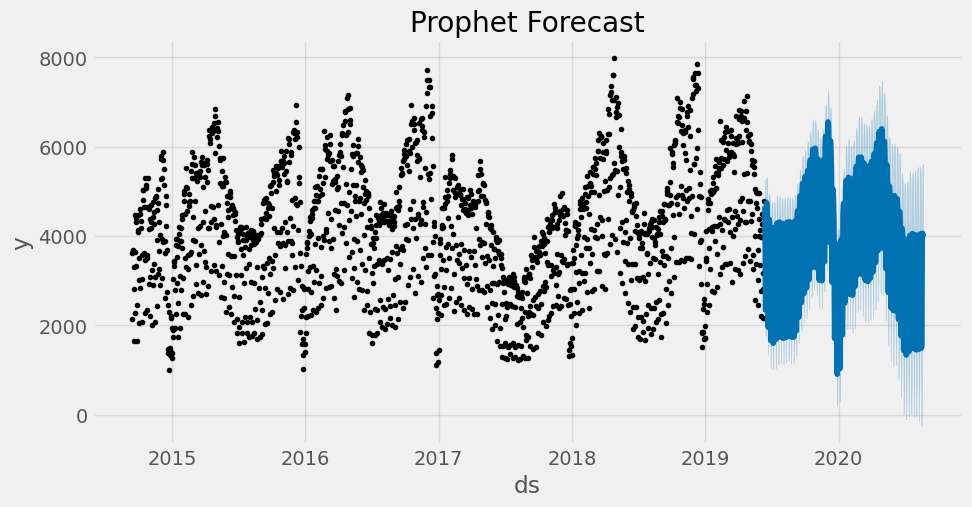

In [11]:
# Plot the forecast
# Creating a plot to visualize the forecasted page loads alongside the actual values
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(df_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

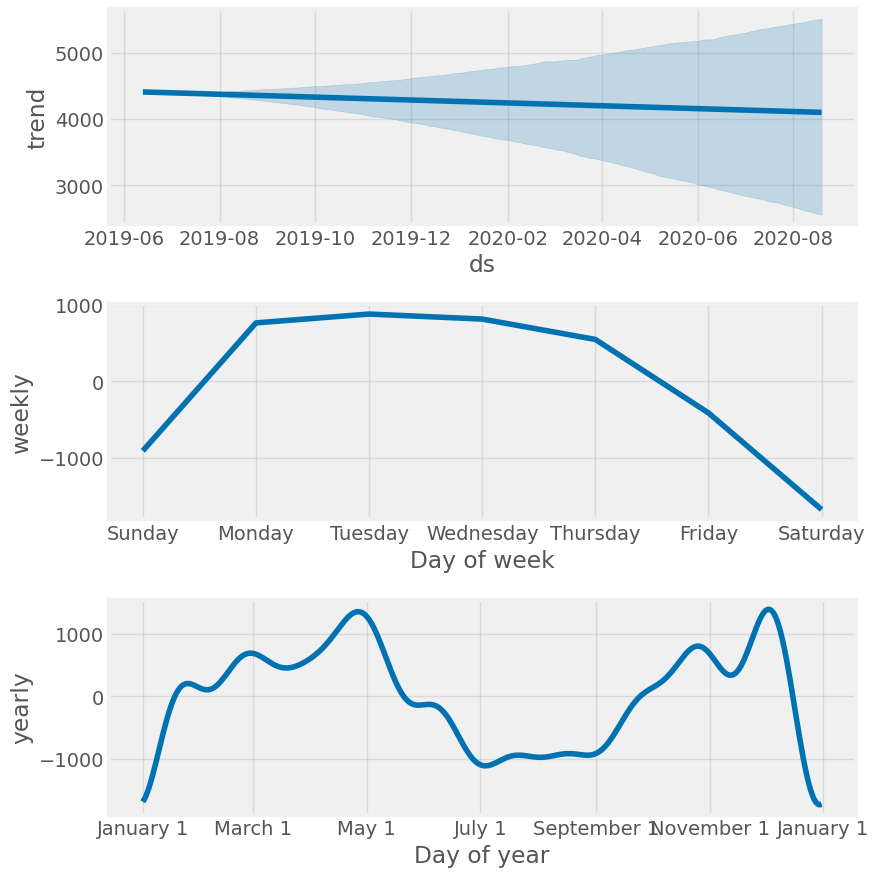

In [12]:
# Plot components analysis
# Generating separate plots to analyze different components of the time series
fig = model.plot_components(df_test_fcst)
plt.show()

# Compare Forecast to Actual Values 

In this code section, we're creating a plot to visually compare the forecasted page loads generated by the Prophet model with the actual observed page loads. The actuals are represented by red scatter points, while the forecasted values are overlaid on the plot. This allows for easy comparison between the predicted and actual values over time.

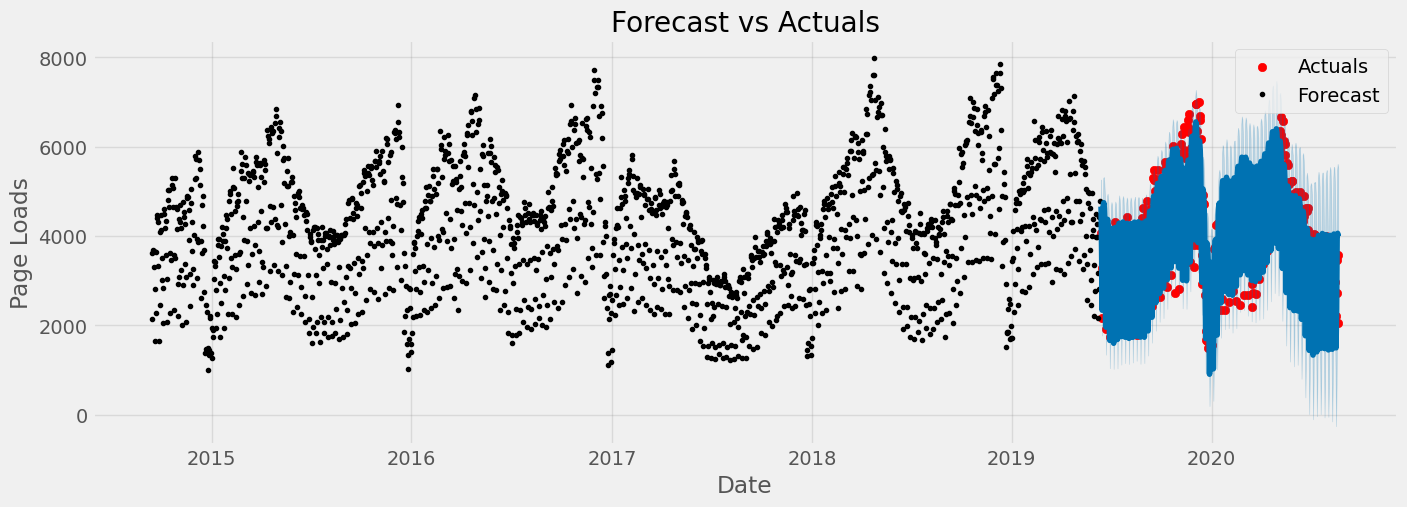

In [13]:
# Plot the forecast with the actuals
# Creating a visualization to compare the forecasted page loads with the actual observed values
f, ax = plt.subplots(figsize=(15, 5))

# Scatter plot of actual page loads
ax.scatter(df_test_prophet['ds'], df_test_prophet['y'], color='r', label='Actuals')

# Plotting the forecasted page loads using the Prophet model
model.plot(df_test_fcst, ax=ax)

# Setting labels and title
ax.set_xlabel('Date')  # X-axis label indicating the date
ax.set_ylabel('Page Loads')  # Y-axis label indicating the page loads
ax.set_title('Forecast vs Actuals')  # Title of the plot

# Adding legend to distinguish between actual and forecasted values
ax.legend(['Actuals', 'Forecast'])

# Displaying the plot
plt.show()

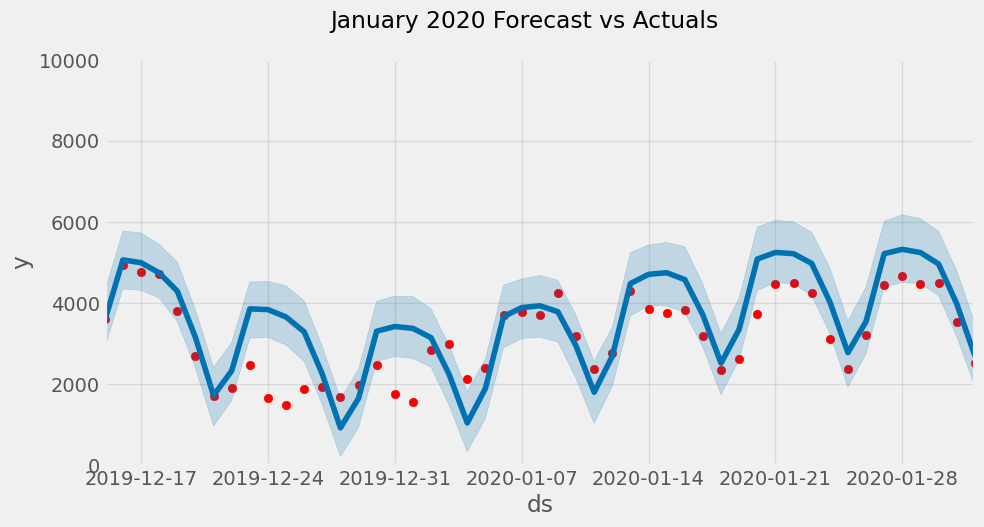

In [14]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test_prophet['ds'], df_test_prophet['y'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

# Set x-axis limits for the specific month
ax.set_xlim(left=pd.Timestamp('2019-12-15'), right=pd.Timestamp('2020-02-01'))

# Set y-axis limits
ax.set_ylim(0, 10000)

# Set the title
plt.suptitle('January 2020 Forecast vs Actuals')

# Show the plot
plt.show()


# Evaluate the model with Error Metrics 

Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE) are commonly used metrics to evaluate the performance of forecasting models. Here's a description of each metric:

Mean Squared Error (MSE):

MSE measures the average squared difference between the actual and forecasted values.
It penalizes large errors more heavily than smaller errors due to the squaring operation.
MSE provides a measure of the overall variance or spread of the errors.
Lower MSE values indicate better model performance, with a perfect model having an MSE of 0.
It is not directly interpretable in the units of the original data.
Mean Absolute Error (MAE):

MAE measures the average absolute difference between the actual and forecasted values.
It provides a more interpretable measure of error compared to MSE since it is in the same units as the original data.
MAE is less sensitive to outliers compared to MSE since it does not square the errors.
Like MSE, lower MAE values indicate better model performance, with a perfect model having an MAE of 0.
Mean Absolute Percentage Error (MAPE):

MAPE measures the average percentage difference between the actual and forecasted values relative to the actual values.
It provides a relative measure of error, making it useful for comparing the performance of models across different datasets or time periods.
MAPE is expressed as a percentage, making it easy to interpret.
However, MAPE has limitations, such as being undefined when the actual values are zero or close to zero and being sensitive to extreme values in the data.
MAPE values can be misleading when the actual values are close to zero.
In practice, all three metrics are widely used for evaluating forecasting models. However, the choice of which metric to use depends on factors such as the specific context of the forecasting problem, the distribution of the data, and the importance of different types of errors.

While MSE, MAE, and MAPE are standard metrics for evaluating forecasting models, it's essential to consider them alongside other diagnostic tools and domain knowledge to gain a comprehensive understanding of the model's performance. Additionally, it's common to use multiple metrics together to provide a more complete assessment of the model's accuracy, robustness, and suitability for the intended application.

In [15]:
# Convert forecasted values to numpy arrays     
actuals = df_test_prophet['y'].values
forecast = df_test_fcst['yhat'].values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actuals, forecast)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, forecast)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - forecast) / actuals)) * 100

print("Mean Squared Error (MSE):", np.sqrt(mse))
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 599.787315602264
Mean Absolute Error (MAE): 456.58112257891867
Mean Absolute Percentage Error (MAPE): 13.096469686166175


# Forecasting 1 month into the future with 1 year training data. From 2019 - 2020

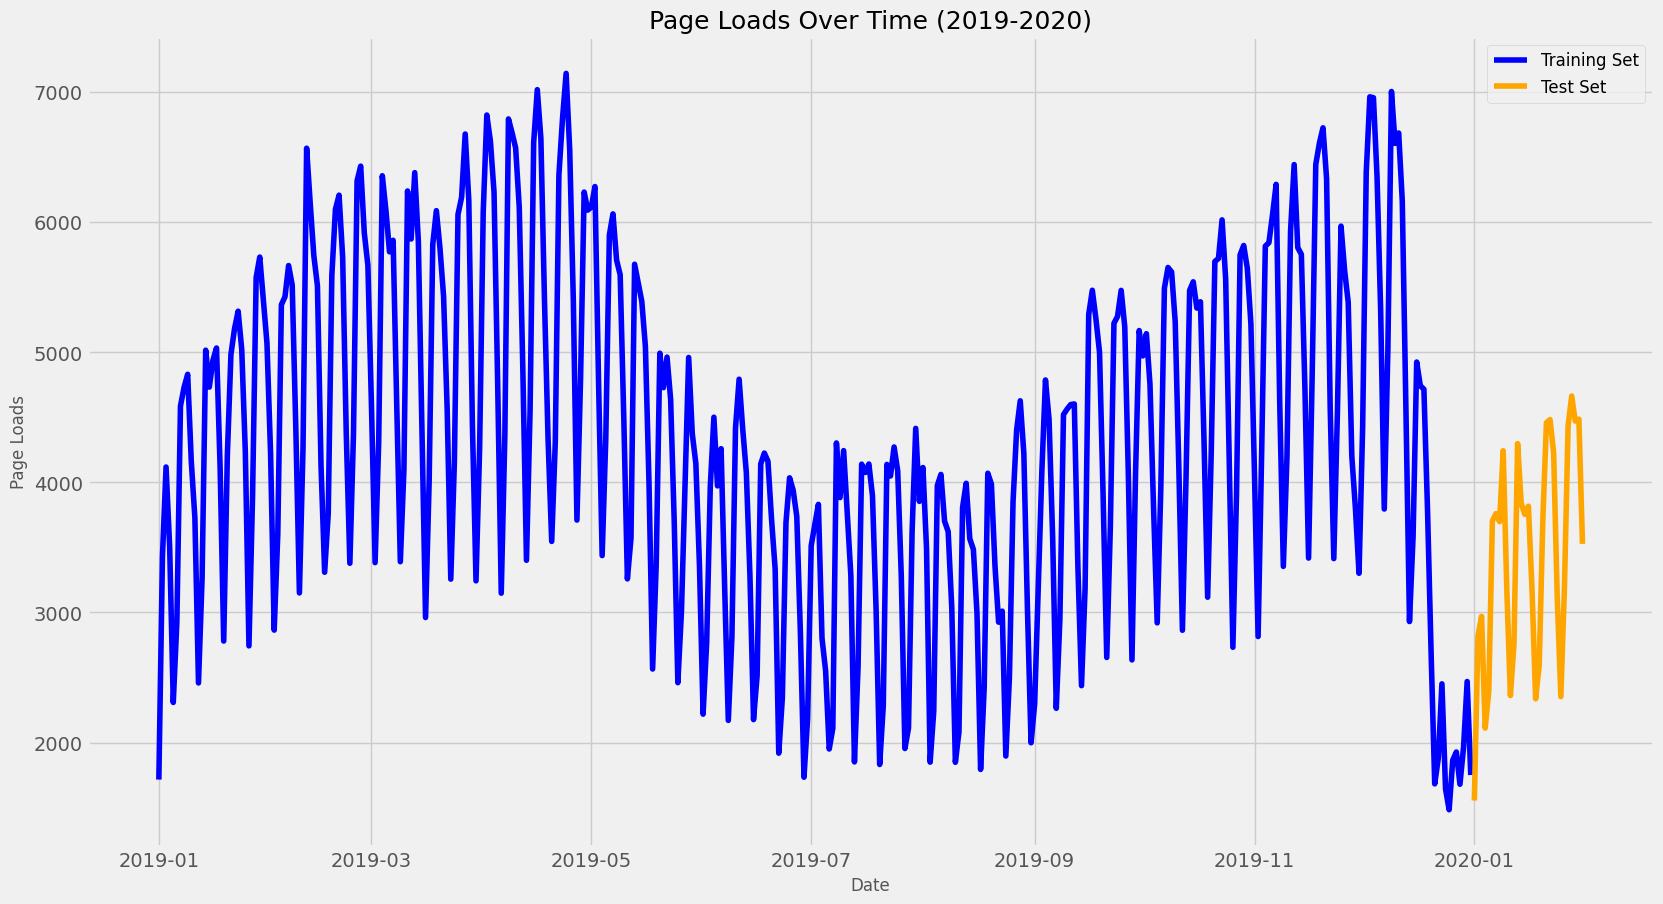

In [16]:
# Define the range for training data and the specific test period

training_end_date = '2020-01-01'
test_start_date = '2019-12-31'
test_end_date = '2020-02-01'

# Filter the data for the desired training range
# Prepare data for 2019-2020
df_2019_2020 = selected_columns[(selected_columns['Date'] >= '2019-01-01') & (selected_columns['Date'] < training_end_date)]

test_2019_2020 = selected_columns[(selected_columns['Date'] > test_start_date) & (selected_columns['Date'] < test_end_date)]
# Split data based on the dates specified
train_2019_2020 = df_2019_2020


# Plotting
plt.figure(figsize=(18, 10))
plt.plot(train_2019_2020['Date'], train_2019_2020['Page.Loads'], label='Training Set', color='blue')
plt.plot(test_2019_2020['Date'], test_2019_2020['Page.Loads'], label='Test Set', color='orange')
plt.title('Page Loads Over Time (2019-2020)', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Page Loads', fontsize=12)
plt.legend(fontsize=12)
plt.show()




### Train model 2019

In [17]:
# Rename columns for Prophet model 
# Renaming columns of the training dataset to adhere to Prophet's expected input format
df_train_prophet_2019_2020 = train_2019_2020.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Create and fit the Prophet model
# Instantiating a Prophet model and training it with the training data
model = Prophet()
model.fit(df_train_prophet_2019_2020)

# Rename columns for Prophet model in the test set
# Renaming columns of the test dataset to match the required format for Prophet
df_test_prophet_2019_2020 = test_2019_2020.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Predict on the test set
# Using the trained Prophet model to make predictions on the test set
df_test_fcst_2019_2020 = model.predict(df_test_prophet_2019_2020)
df_test_fcst_2019_2020.head()







15:24:40 - cmdstanpy - INFO - Chain [1] start processing
15:24:40 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,4515.335884,4349.928674,6370.679789,4515.335884,4515.335884,839.428726,839.428726,839.428726,839.428726,839.428726,839.428726,0.0,0.0,0.0,5354.764610
1,2020-01-02,4517.326201,4108.084682,5966.828840,4517.326201,4517.326201,543.125458,543.125458,543.125458,543.125458,543.125458,543.125458,0.0,0.0,0.0,5060.451659
2,2020-01-03,4519.316519,3104.623864,5000.389414,4519.316519,4520.388092,-441.852643,-441.852643,-441.852643,-441.852643,-441.852643,-441.852643,0.0,0.0,0.0,4077.463876
3,2020-01-04,4521.306836,1948.354971,3844.303441,4520.772066,4523.734286,-1652.324019,-1652.324019,-1652.324019,-1652.324019,-1652.324019,-1652.324019,0.0,0.0,0.0,2868.982817
4,2020-01-05,4523.297154,2671.259189,4571.140352,4521.335046,4527.439561,-857.938890,-857.938890,-857.938890,-857.938890,-857.938890,-857.938890,0.0,0.0,0.0,3665.358264


### Plot the forecast 2019

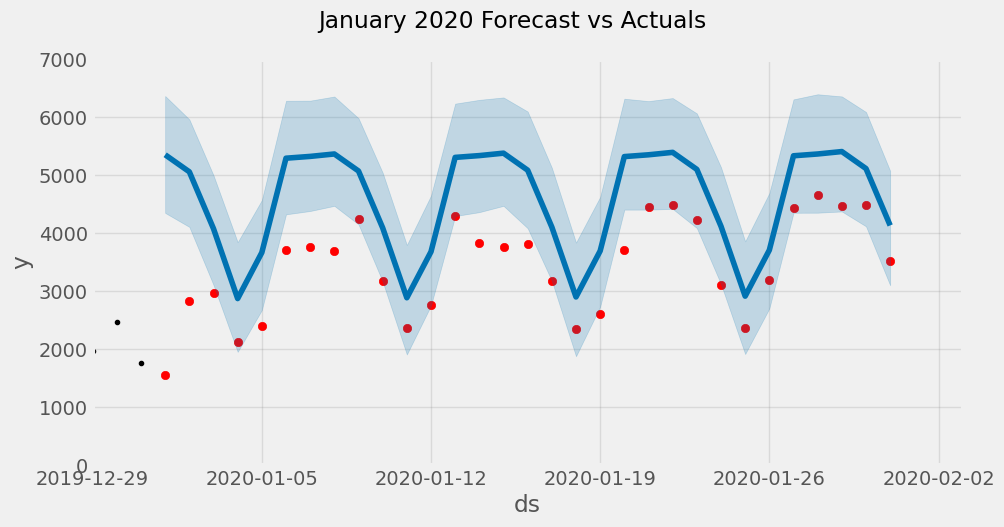

In [18]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test_prophet_2019_2020['ds'], df_test_prophet_2019_2020['y'], color='r')
fig = model.plot(df_test_fcst_2019_2020, ax=ax)

# Set x-axis limits for the specific month
ax.set_xlim(left=pd.Timestamp('2019-12-29'), right=pd.Timestamp('2020-02-03'))

# Set y-axis limits
ax.set_ylim(0, 7000)

# Set the title
plt.suptitle('January 2020 Forecast vs Actuals')

# Show the plot
plt.show()

### Calculating the mean 2019

In [19]:
# Convert forecasted values to numpy arrays     
actuals = df_test_prophet_2019_2020['y'].values
forecast = df_test_fcst_2019_2020['yhat'].values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actuals, forecast)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, forecast)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - forecast) / actuals)) * 100

print("Mean Squared Error (MSE):", np.sqrt(mse))
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 1304.8164372228498
Mean Absolute Error (MAE): 1140.3100507077927
Mean Absolute Percentage Error (MAPE): 38.16524629347277


# Forecasting 1 month into the future with 2 years training data. From 2018 - 2020

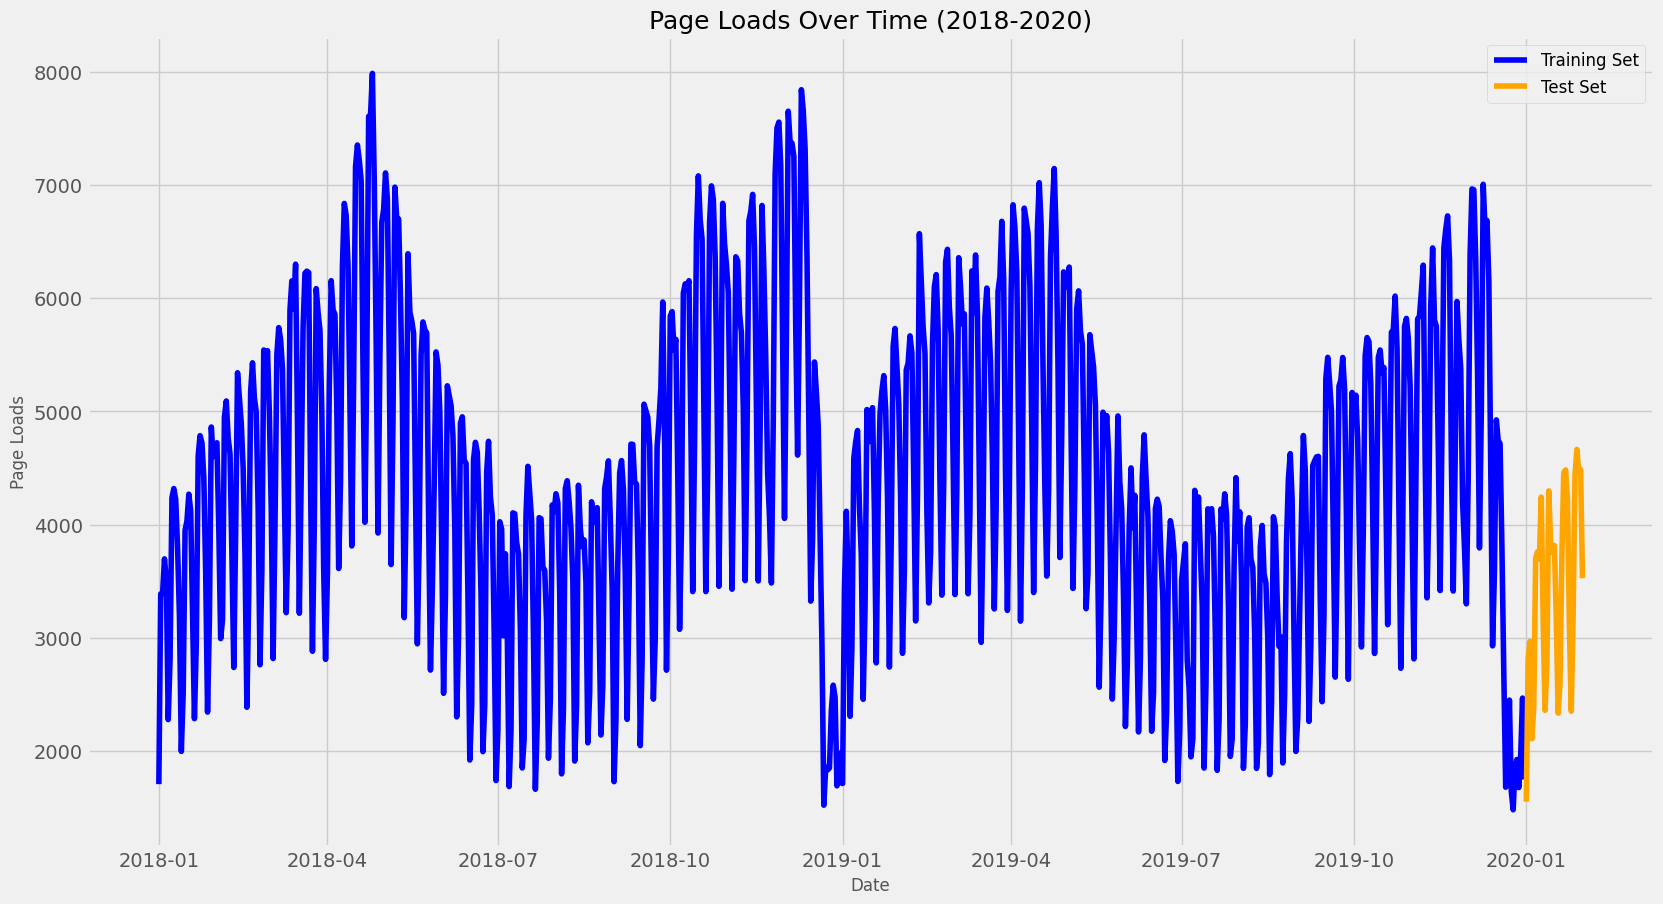

In [20]:
# Filter the data for the desired training range
# Prepare data for 2018-2020
df_2018_2020 = selected_columns[(selected_columns['Date'] >= '2018-01-01') & (selected_columns['Date'] < training_end_date)]

test_2018_2020 = selected_columns[(selected_columns['Date'] > test_start_date) & (selected_columns['Date'] < test_end_date)]
# Split data based on the dates specified
train_2018_2020 = df_2018_2020[df_2018_2020['Date'] <= training_end_date]

# Plotting
plt.figure(figsize=(18, 10))
plt.plot(train_2018_2020['Date'], train_2018_2020['Page.Loads'], label='Training Set', color='blue')
plt.plot(test_2018_2020['Date'], test_2018_2020['Page.Loads'], label='Test Set', color='orange')
plt.title('Page Loads Over Time (2018-2020)', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Page Loads', fontsize=12)
plt.legend(fontsize=12)
plt.show()


### Training the model 2018

In [21]:
# Rename columns for Prophet model 
# Renaming columns of the training dataset to adhere to Prophet's expected input format
df_train_prophet_2018_2020 = train_2018_2020.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Create and fit the Prophet model
# Instantiating a Prophet model and training it with the training data
model = Prophet()
model.fit(df_train_prophet_2018_2020)

# Rename columns for Prophet model in the test set
# Renaming columns of the test dataset to match the required format for Prophet
df_test_prophet_2018_2020 = test_2018_2020.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Predict on the test set
# Using the trained Prophet model to make predictions on the test set
df_test_fcst_2018_2020 = model.predict(df_test_prophet_2018_2020)
df_test_fcst_2018_2020.head()



15:24:41 - cmdstanpy - INFO - Chain [1] start processing
15:24:41 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,4144.262517,3668.255920,6324.009850,4144.262517,4144.262517,824.022867,824.022867,824.022867,824.022867,824.022867,824.022867,0.0,0.0,0.0,4968.285384
1,2020-01-02,4143.436152,3277.075425,5955.451571,4143.436152,4143.436152,569.631254,569.631254,569.631254,569.631254,569.631254,569.631254,0.0,0.0,0.0,4713.067407
2,2020-01-03,4142.609788,2443.576920,5058.516015,4142.609788,4142.609788,-425.355202,-425.355202,-425.355202,-425.355202,-425.355202,-425.355202,0.0,0.0,0.0,3717.254585
3,2020-01-04,4141.783423,1108.126124,3827.353055,4141.783423,4141.783423,-1711.183054,-1711.183054,-1711.183054,-1711.183054,-1711.183054,-1711.183054,0.0,0.0,0.0,2430.600369
4,2020-01-05,4140.957058,1928.774662,4577.395739,4140.957058,4140.957058,-885.111611,-885.111611,-885.111611,-885.111611,-885.111611,-885.111611,0.0,0.0,0.0,3255.845447


### Plotting the forecast 2018

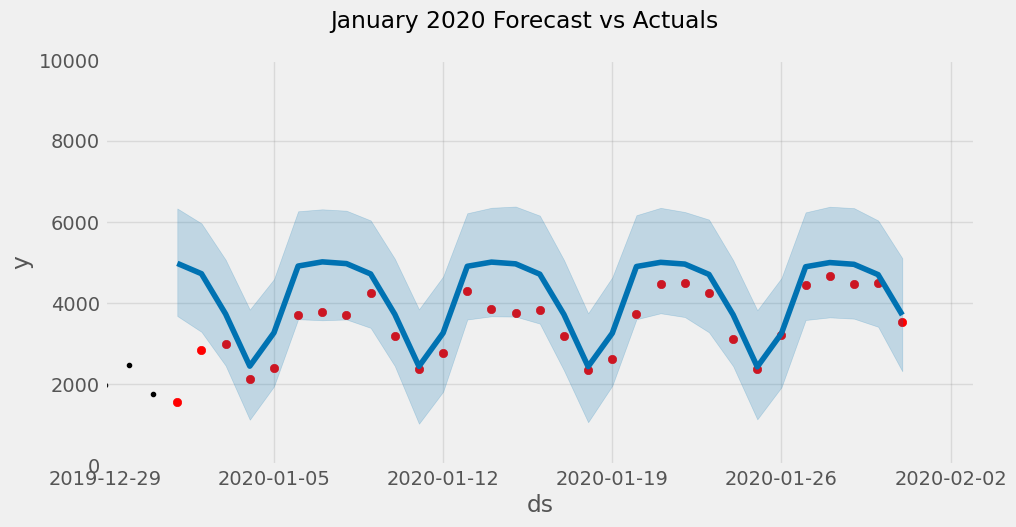

In [22]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test_prophet_2018_2020['ds'], df_test_prophet_2018_2020['y'], color='r')
fig = model.plot(df_test_fcst_2018_2020, ax=ax)

# Set x-axis limits for the specific month
ax.set_xlim(left=pd.Timestamp('2019-12-29'), right=pd.Timestamp('2020-02-03'))

# Set y-axis limits
ax.set_ylim(0, 10000)

# Set the title
plt.suptitle('January 2020 Forecast vs Actuals')

# Show the plot
plt.show()

### Calculating the mean value 2018

In [23]:
# Convert forecasted values to numpy arrays     
actuals = df_test_prophet_2018_2020['y'].values
forecast = df_test_fcst_2018_2020['yhat'].values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actuals, forecast)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, forecast)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - forecast) / actuals)) * 100

print("Mean Squared Error (MSE):", np.sqrt(mse))
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 978.5279696079778
Mean Absolute Error (MAE): 727.8766887073197
Mean Absolute Percentage Error (MAPE): 25.18085001846923


# Forecasting 1 month into the future with 3 years training data. From 2017 - 2020

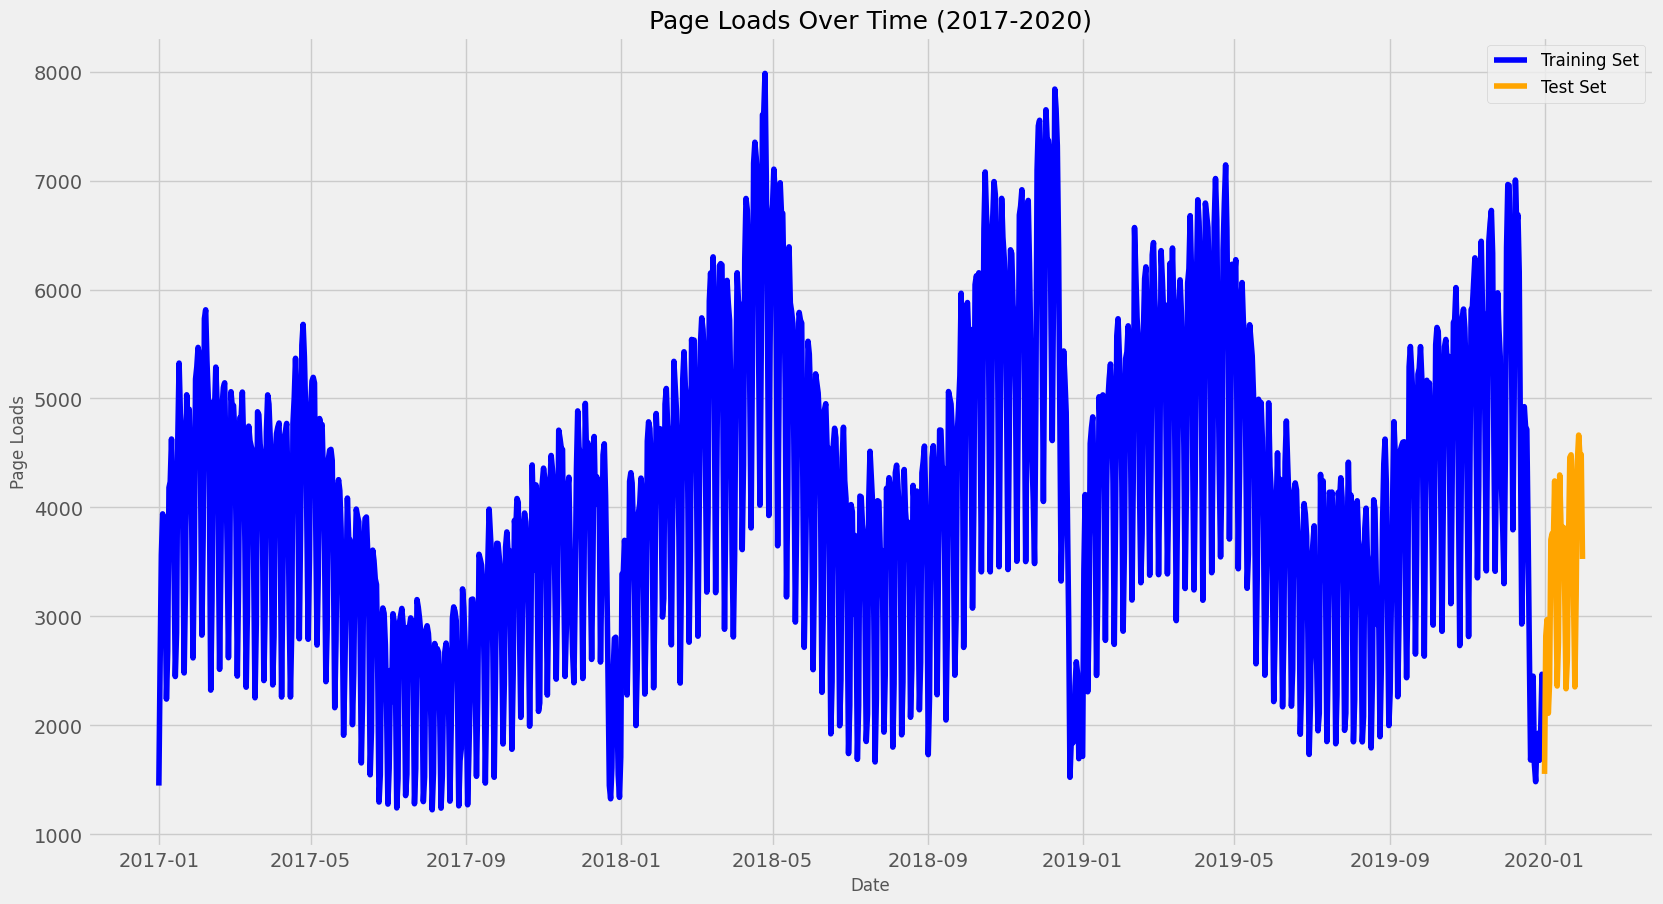

In [24]:
# Filter the data for the desired training range
# Prepare data for 2018-2020
df_2017_2020 = selected_columns[(selected_columns['Date'] >= '2017-01-01') & (selected_columns['Date'] < training_end_date)]

test_2017_2020 = selected_columns[(selected_columns['Date'] > test_start_date) & (selected_columns['Date'] < test_end_date)]
# Split data based on the dates specified
train_2017_2020 = df_2017_2020[df_2017_2020['Date'] <= training_end_date]

# Plotting
plt.figure(figsize=(18, 10))
plt.plot(train_2017_2020['Date'], train_2017_2020['Page.Loads'], label='Training Set', color='blue')
plt.plot(test_2017_2020['Date'], test_2017_2020['Page.Loads'], label='Test Set', color='orange')
plt.title('Page Loads Over Time (2017-2020)', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Page Loads', fontsize=12)
plt.legend(fontsize=12)
plt.show()


### Training the model 2017

In [25]:
# Rename columns for Prophet model 
# Renaming columns of the training dataset to adhere to Prophet's expected input format
df_train_prophet_2017_2020 = train_2017_2020.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Create and fit the Prophet model
# Instantiating a Prophet model and training it with the training data
model = Prophet()
model.fit(df_train_prophet_2017_2020)

# Rename columns for Prophet model in the test set
# Renaming columns of the test dataset to match the required format for Prophet
df_test_prophet_2017_2020 = test_2017_2020.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Predict on the test set
# Using the trained Prophet model to make predictions on the test set
df_test_fcst_2017_2020 = model.predict(df_test_prophet_2017_2020)
df_test_fcst_2017_2020.tail()

15:24:42 - cmdstanpy - INFO - Chain [1] start processing
15:24:42 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
26,2020-01-27,4101.248732,4642.486892,5778.113007,4090.202876,4110.524379,1103.552275,1103.552275,1103.552275,706.371123,706.371123,706.371123,397.181152,397.181152,397.181152,0.0,0.0,0.0,5204.801006
27,2020-01-28,4100.068630,4722.406245,5865.279903,4088.253490,4110.036681,1211.255208,1211.255208,1211.255208,824.204222,824.204222,824.204222,387.050986,387.050986,387.050986,0.0,0.0,0.0,5311.323838
28,2020-01-29,4098.888528,4600.854493,5832.172049,4085.995663,4109.774481,1151.037954,1151.037954,1151.037954,778.197126,778.197126,778.197126,372.840829,372.840829,372.840829,0.0,0.0,0.0,5249.926482
29,2020-01-30,4097.708426,4349.046012,5591.402442,4083.854864,4109.797191,900.282669,900.282669,900.282669,544.440138,544.440138,544.440138,355.842531,355.842531,355.842531,0.0,0.0,0.0,4997.991094
30,2020-01-31,4096.528324,3471.049177,4636.536424,4082.047990,4109.882136,-51.722058,-51.722058,-51.722058,-389.044854,-389.044854,-389.044854,337.322796,337.322796,337.322796,0.0,0.0,0.0,4044.806266


### Plotting the forecast 2017

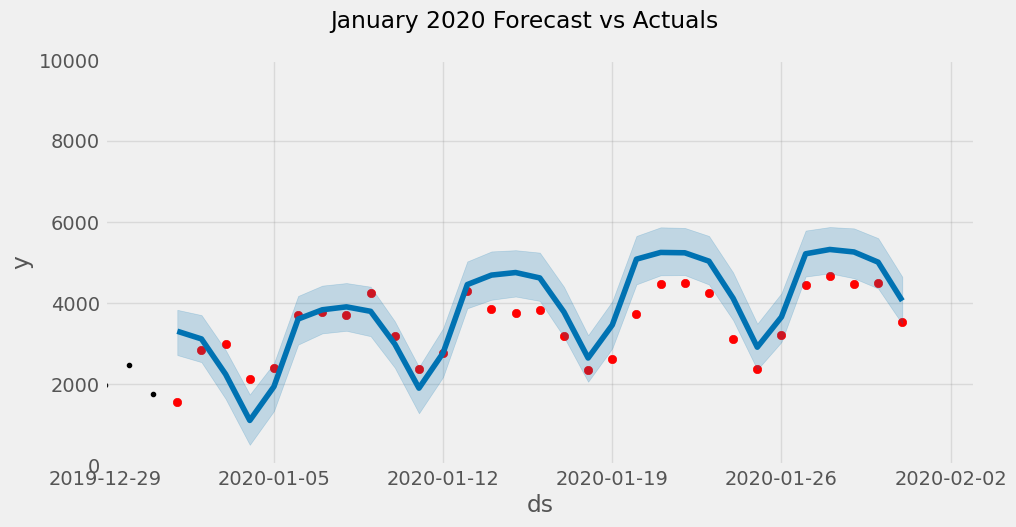

In [26]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test_prophet_2017_2020['ds'], df_test_prophet_2017_2020['y'], color='r')
fig = model.plot(df_test_fcst_2017_2020, ax=ax)

# Set x-axis limits for the specific month
ax.set_xlim(left=pd.Timestamp('2019-12-29'), right=pd.Timestamp('2020-02-03'))

# Set y-axis limits
ax.set_ylim(0, 10000)

# Set the title
plt.suptitle('January 2020 Forecast vs Actuals')

# Show the plot
plt.show()

### Calculating the mean value 2017

In [27]:
# Convert forecasted values to numpy arrays     
actuals = df_test_prophet_2017_2020['y'].values
forecast = df_test_fcst_2017_2020['yhat'].values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actuals, forecast)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, forecast)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - forecast) / actuals)) * 100

print("Mean Squared Error (MSE):", np.sqrt(mse))
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 723.238371081371
Mean Absolute Error (MAE): 617.9663496459298
Mean Absolute Percentage Error (MAPE): 20.38335026468845


# Forecasting 1 month into the future with 4 years training data. From 2016 - 2020

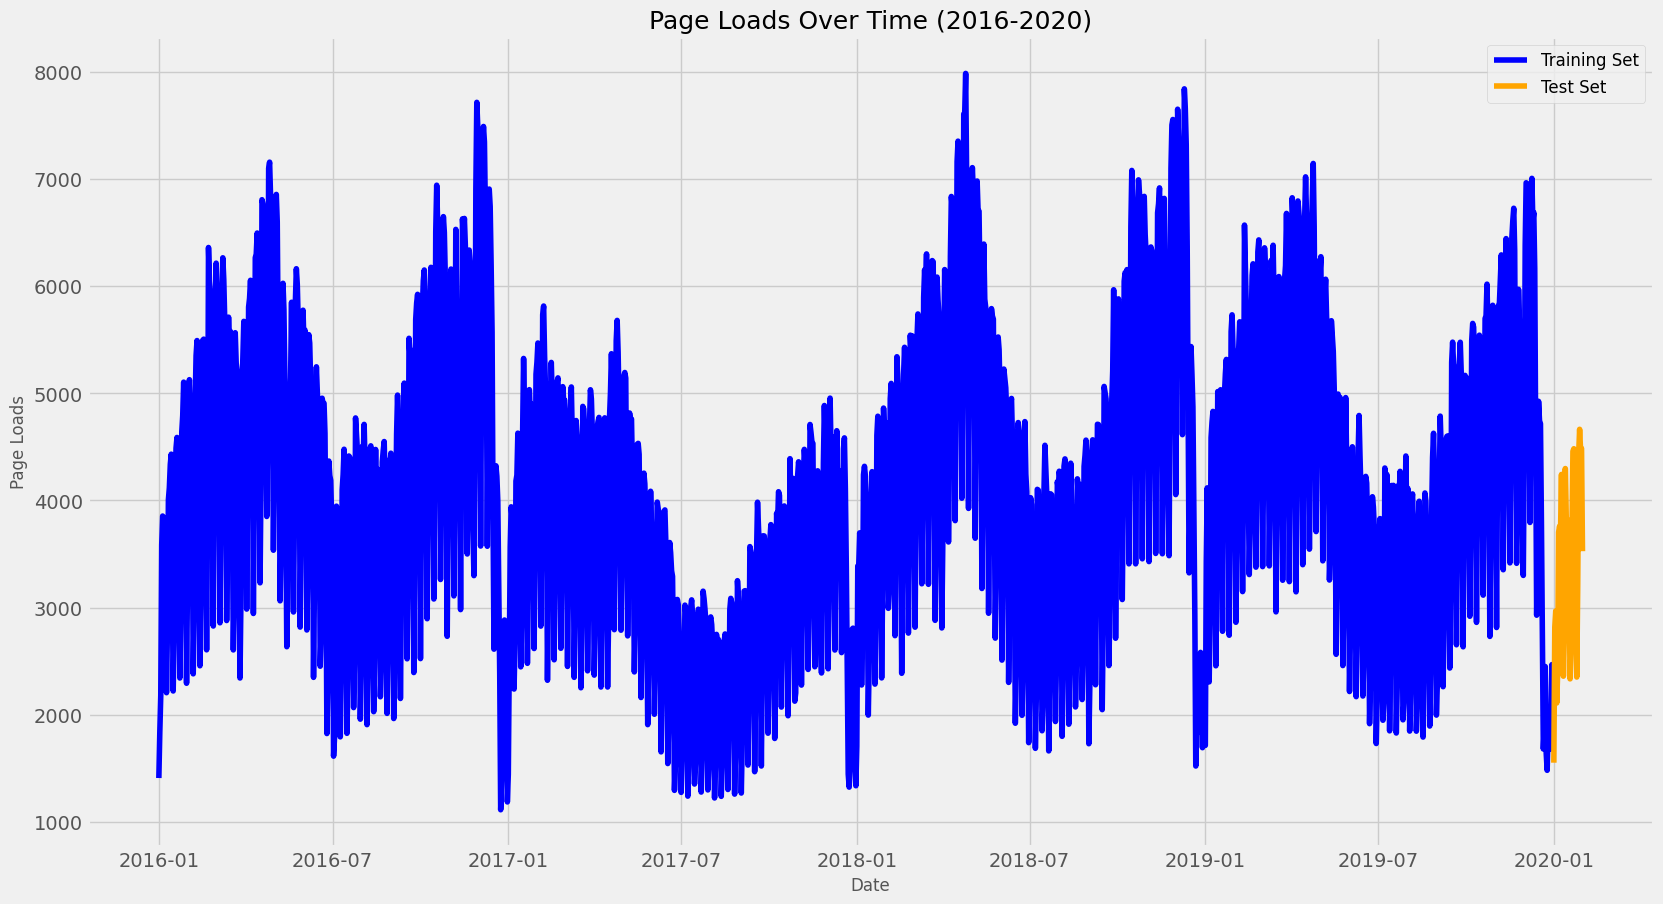

In [28]:
# Filter the data for the desired training range
# Prepare data for 2018-2020
df_2016_2020 = selected_columns[(selected_columns['Date'] >= '2016-01-01') & (selected_columns['Date'] < training_end_date)]

test_2016_2020 = selected_columns[(selected_columns['Date'] > test_start_date) & (selected_columns['Date'] < test_end_date)]
# Split data based on the dates specified
train_2016_2020 = df_2016_2020[df_2016_2020['Date'] <= training_end_date]


# Plotting
plt.figure(figsize=(18, 10))
plt.plot(train_2016_2020['Date'], train_2016_2020['Page.Loads'], label='Training Set', color='blue')
plt.plot(test_2016_2020['Date'], test_2016_2020['Page.Loads'], label='Test Set', color='orange')
plt.title('Page Loads Over Time (2016-2020)', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Page Loads', fontsize=12)
plt.legend(fontsize=12)
plt.show()




### Training the model 2016

In [29]:
# Rename columns for Prophet model 
# Renaming columns of the training dataset to adhere to Prophet's expected input format
df_train_prophet_2016_2020 = train_2016_2020.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Create and fit the Prophet model
# Instantiating a Prophet model and training it with the training data
model = Prophet()
model.fit(df_train_prophet_2016_2020)

# Rename columns for Prophet model in the test set
# Renaming columns of the test dataset to match the required format for Prophet
df_test_prophet_2016_2020 = test_2016_2020.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Predict on the test set
# Using the trained Prophet model to make predictions on the test set
df_test_fcst_2016_2020 = model.predict(df_test_prophet_2016_2020)
df_test_fcst_2016_2020.head()

15:24:43 - cmdstanpy - INFO - Chain [1] start processing
15:24:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,4105.168062,2715.695456,3859.442763,4105.168062,4105.168062,-820.403666,-820.403666,-820.403666,822.342537,822.342537,822.342537,-1642.746203,-1642.746203,-1642.746203,0.0,0.0,0.0,3284.764397
1,2020-01-02,4103.882368,2468.395762,3643.757908,4103.882368,4103.882368,-1044.898481,-1044.898481,-1044.898481,559.420517,559.420517,559.420517,-1604.318997,-1604.318997,-1604.318997,0.0,0.0,0.0,3058.983887
2,2020-01-03,4102.596674,1557.504702,2678.678386,4102.596674,4102.596674,-1954.588486,-1954.588486,-1954.588486,-405.962459,-405.962459,-405.962459,-1548.626027,-1548.626027,-1548.626027,0.0,0.0,0.0,2148.008188
3,2020-01-04,4101.310980,429.838364,1523.359106,4101.310980,4101.310980,-3144.252902,-3144.252902,-3144.252902,-1667.025664,-1667.025664,-1667.025664,-1477.227238,-1477.227238,-1477.227238,0.0,0.0,0.0,957.058079
4,2020-01-05,4100.025286,1221.060002,2440.731342,4100.025286,4100.025286,-2296.006958,-2296.006958,-2296.006958,-904.086253,-904.086253,-904.086253,-1391.920705,-1391.920705,-1391.920705,0.0,0.0,0.0,1804.018328


### Plotting the forecast 2016

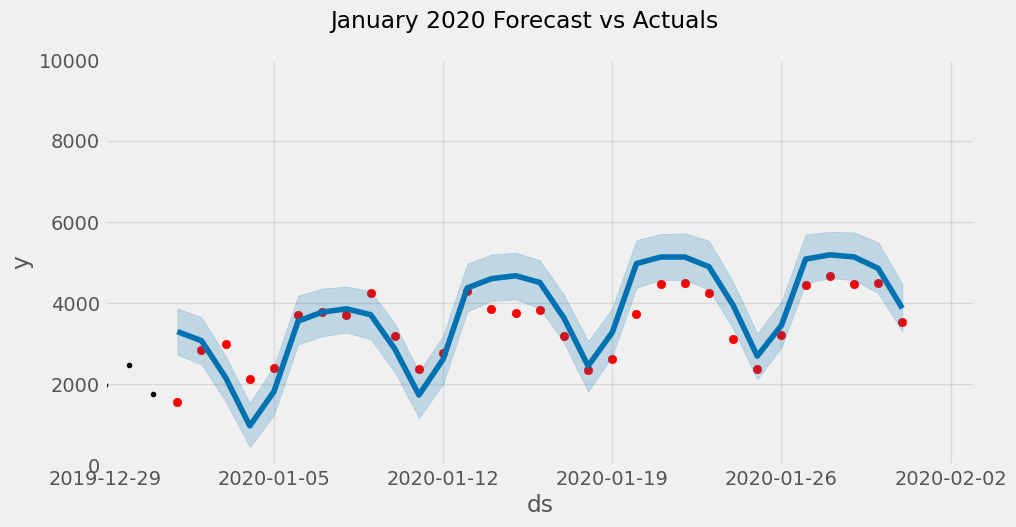

In [30]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_test_prophet_2016_2020['ds'], df_test_prophet_2016_2020['y'], color='r')
fig = model.plot(df_test_fcst_2016_2020, ax=ax)

# Set x-axis limits for the specific month
ax.set_xlim(left=pd.Timestamp('2019-12-29'), right=pd.Timestamp('2020-02-03'))

# Set y-axis limits
ax.set_ylim(0, 10000)

# Set the title
plt.suptitle('January 2020 Forecast vs Actuals')

# Show the plot
plt.show()

### Calculating mean value 2016

In [31]:
# Convert forecasted values to numpy arrays     
actuals = df_test_prophet_2016_2020['y'].values
forecast = df_test_fcst_2016_2020['yhat'].values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actuals, forecast)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, forecast)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - forecast) / actuals)) * 100

print("Mean Squared Error (MSE):", np.sqrt(mse))
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 668.2626076474793
Mean Absolute Error (MAE): 556.3071723676449
Mean Absolute Percentage Error (MAPE): 18.783713255044553
